In [ ]:
import os
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
feats=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_train.npy")
labels=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_train.npy")

In [ ]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

3703


In [ ]:
print(num_classes)

3


In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

In [ ]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

In [ ]:
input_shape = x_test[0,:,:,:].shape
model_input = Input(shape=input_shape)

mobilenetv2

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
mobilenet_model = Model(conv_base.input, predictions)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
mobilenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
mobilenet_model.load_weights('/content/drive/My Drive/skin_model/MobileNetV2withisic2019.h5')

In [ ]:
mobilenet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

VGG19

In [ ]:
vgg_model = VGG19(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [ ]:
for layer in vgg_model.layers:
    print(layer.name)
    layer.trainable = False

print(len(vgg_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
22


In [ ]:
last_layer = vgg_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(vgg_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
vgg_model.load_weights("/content/drive/My Drive/skin_model/VGG19.h5")

In [ ]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#InceptionV3

In [ ]:
inception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [ ]:
for layer in inception.layers:
    layer.trainable = True

In [ ]:
inception_last_layer = inception.get_layer('mixed10')
print('last layer output shape:', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

last layer output shape: (None, 5, 5, 2048)


In [ ]:
# Flatten the output layer to 1 dimension
x_inception = layers.GlobalMaxPooling2D()(inception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_inception = layers.Dense(512, activation='relu')(x_inception)
# Add a dropout rate of 0.7
x_inception = layers.Dropout(0.5)(x_inception)
# Add a final sigmoid layer for classification
x_inception = layers.Dense(7, activation='softmax')(x_inception)

# Configure and compile the model

inception_model = Model(model_input, x_inception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
inception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
inception_model.load_weights("/content/drive/My Drive/skin_model/InceptionV3.h5")

In [ ]:
inception_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 95, 127, 32)  96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

In [ ]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = layers.Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

In [ ]:
ensemble_model = ensemble([inception_model,vgg_model,mobilenet_model], model_input)

In [ ]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
loss_val, acc_val = ensemble_model.evaluate(x_test, y_test, verbose=1)

26/26 [==============================] - 10s 368ms/step - loss: 0.4431 - accuracy: 0.8753


In [ ]:
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

Validation: accuracy = 0.875312  ;  loss_v = 0.443082


In [ ]:
loss_test, acc_test = ensemble_model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

63/63 [==============================] - 24s 381ms/step - loss: 0.4871 - accuracy: 0.8592
Test: accuracy = 0.859211  ;  loss = 0.487124


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002790FEC5108>:
              precision    recall  f1-score   support

     class 0       0.59      0.42      0.49        24
     class 1       0.82      0.70      0.76        47
     class 2       0.58      0.72      0.64        79
     class 3       0.82      0.75      0.78        12
     class 4       0.92      0.93      0.92       549
     class 5       0.59      0.49      0.54        81
     class 6       0.80      0.80      0.80        10

    accuracy                           0.83       802
   macro avg       0.73      0.69      0.70       802
weighted avg       0.83      0.83      0.83       802




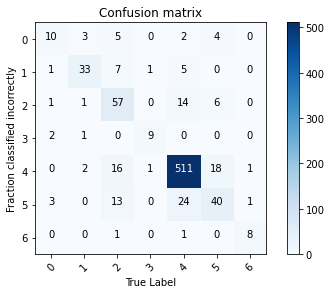

In [ ]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4',
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [ ]:
ensemble_model.save("/content/drive/My Drive/skin_model/ensemble.h5")

test set

In [ ]:
feats_test=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_test.npy")
labels_test=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

155


In [ ]:
x_test = feats_test.astype('float32')/255
y_test=to_categorical(labels_test,3)

In [ ]:
model = load_model('/content/drive/My Drive/skin_model/ensemble.h5')

In [ ]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [ ]:
from keras.preprocessing.image import img_to_array

In [ ]:
from IPython.display import  display
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  print(pred)
  #pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]

  return pred

5/5 [==============================] - 7s 2s/step


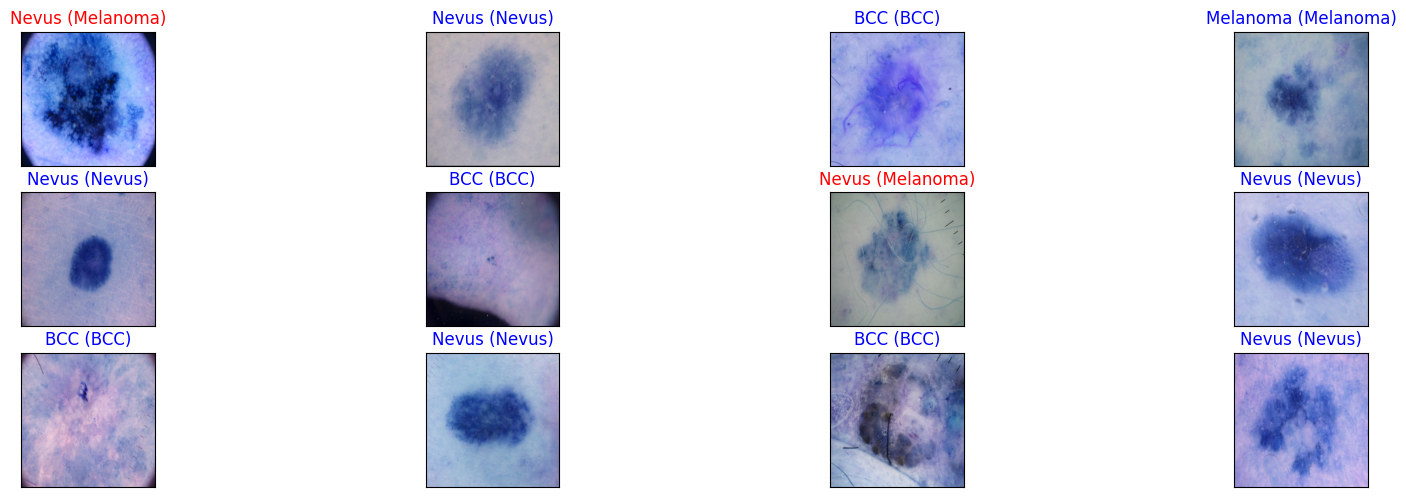

In [ ]:
y_hat = model.predict(x_test)

# define text labels
skin_labels = ['BCC','Melanoma','Nevus']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))